In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, SimpleRNN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



data = pd.read_csv('/content/seattle-weather.csv')
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


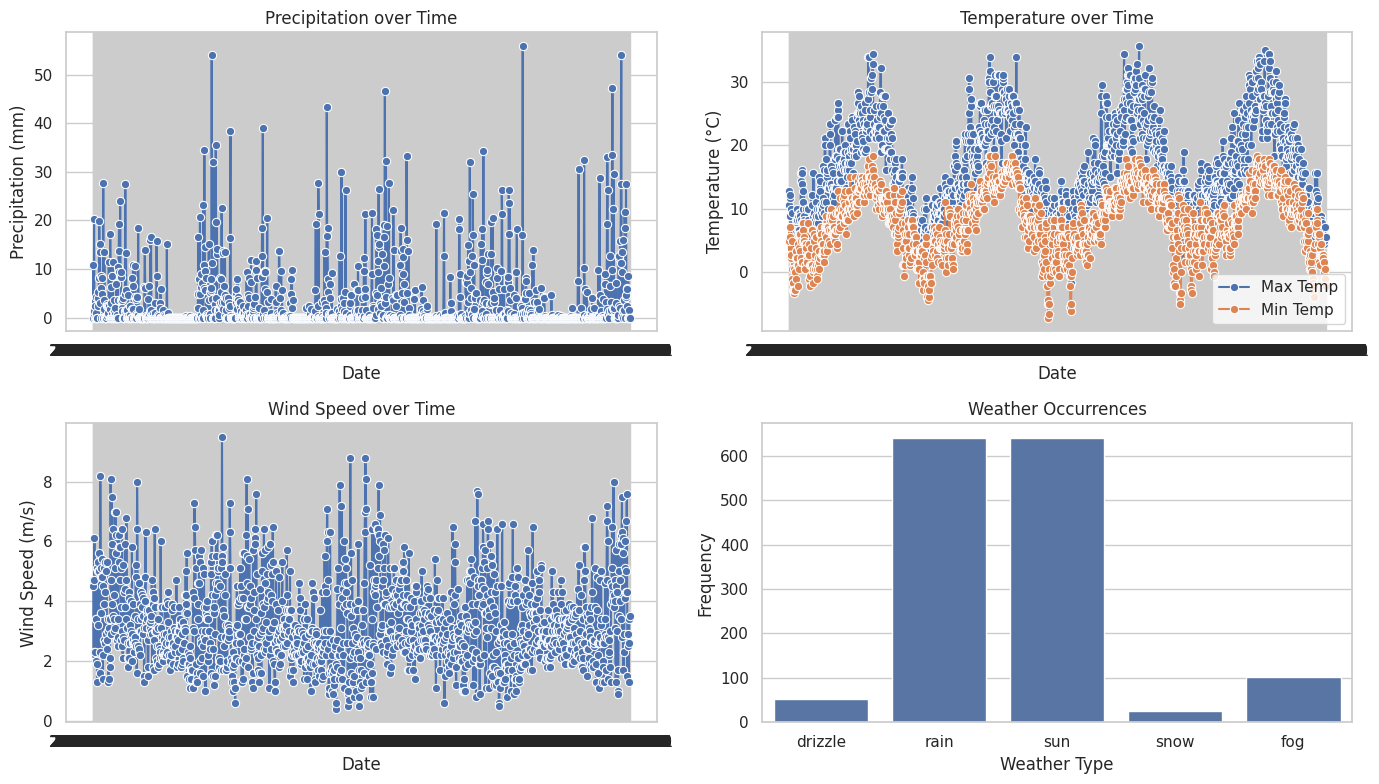

In [ ]:

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(14, 8))

# Subplot 1: Precipitation over time
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='precipitation', data=data, marker='o')
plt.title('Precipitation over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')

# Subplot 2: Temperature over time
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='temp_max', data=data, marker='o', label='Max Temp')
sns.lineplot(x='date', y='temp_min', data=data, marker='o', label='Min Temp')
plt.title('Temperature over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Subplot 3: Wind speed over time
plt.subplot(2, 2, 3)
sns.lineplot(x='date', y='wind', data=data, marker='o')
plt.title('Wind Speed over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')

# Subplot 4: Weather occurrences
plt.subplot(2, 2, 4)
sns.countplot(x='weather', data=data)
plt.title('Weather Occurrences')
plt.xlabel('Weather Type')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

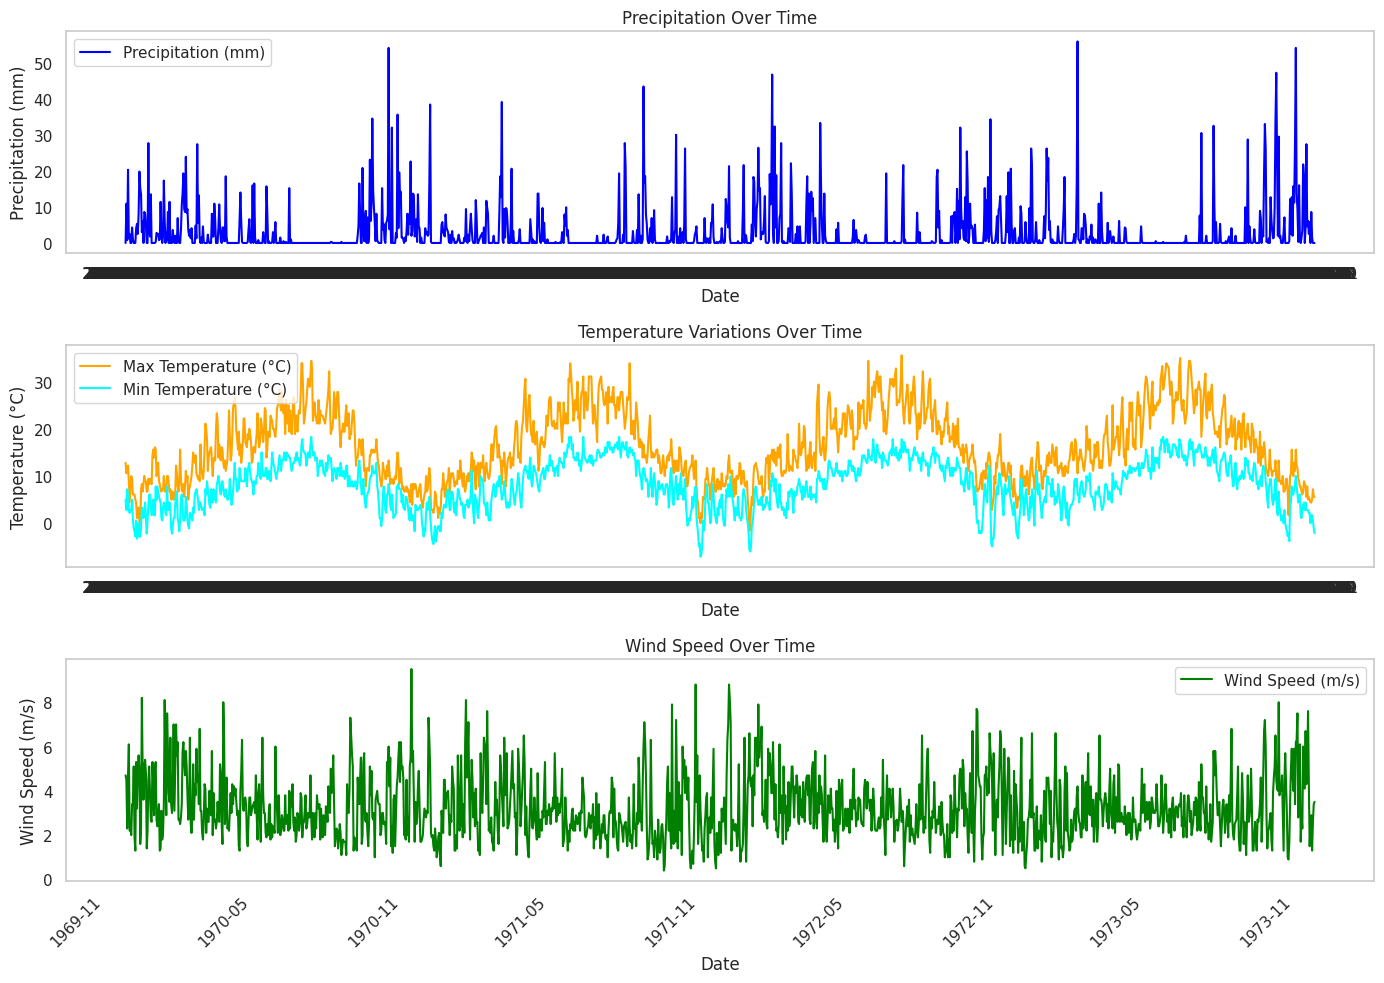

In [ ]:
import matplotlib.dates as mdates
# Time Series Graphs
plt.figure(figsize=(14, 10))

# Subplot 1: Precipitation over time
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['precipitation'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid()

# Subplot 2: Temperature variations over time (Max and Min)
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['temp_max'], label='Max Temperature (°C)', color='orange')
plt.plot(data['date'], data['temp_min'], label='Min Temperature (°C)', color='cyan')
plt.title('Temperature Variations Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()

# Subplot 3: Wind Speed over time
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['wind'], label='Wind Speed (m/s)', color='green')
plt.title('Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [ ]:
# Convert date to datetime if not already in datetime format
data['date'] = pd.to_datetime(data['date'])


In [ ]:

# Feature selection
# Selecting features: 'precipitation', 'temp_max', 'temp_min', 'wind'
selected_features = ['precipitation', 'temp_max', 'temp_min', 'wind']

# Normalizing the data (standardization)
scaler = StandardScaler()
data[selected_features] = scaler.fit_transform(data[selected_features])


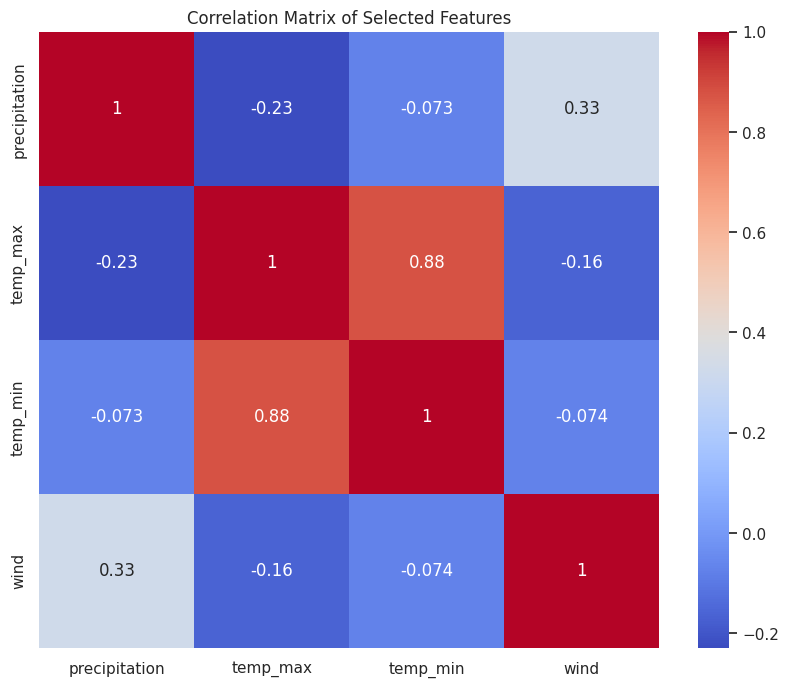

In [ ]:
# Visualizing correlations between features
plt.figure(figsize=(10, 8))
correlation_matrix = data[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()




In [ ]:
# Applying SelectKBest to select top features (using f_regression here as an example)
X = data[selected_features]
# Convert 'weather' to numerical labels using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data['weather'])

# Using SelectKBest to select features based on their correlation with the target
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

SelectKBest(k='all', score_func=<function f_regression at 0x7877972ba290>)

In [ ]:
# Display scores of the features
feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': selector.scores_})
print(feature_scores)

# Selecting the final set of features based on scores (threshold can be adjusted)
selected_features_final = feature_scores[feature_scores['Score'] > 0.1]['Feature'].tolist()
print("Selected features:", selected_features_final)

         Feature       Score
0  precipitation  112.345093
1       temp_max  169.168656
2       temp_min   35.906536
3           wind    6.355612
Selected features: ['precipitation', 'temp_max', 'temp_min', 'wind']


In [ ]:
# Balancing 'drizzle' and 'sun' classes (oversampling)
from sklearn.utils import resample

data_balanced = pd.concat([
    resample(data[data['weather'] == 'drizzle'], replace=True, n_samples=len(data[data['weather'] == 'sun']), random_state=42),
    data[data['weather'] != 'drizzle']
])

X = data_balanced[selected_features]
y = le.fit_transform(data_balanced['weather'])

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


Accuracy: 86.83%

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.90      1.00      0.95       138
         fog       0.29      0.09      0.13        23
        rain       0.96      0.90      0.93       116
        snow       0.67      0.50      0.57         4
         sun       0.79      0.85      0.82       129

    accuracy                           0.87       410
   macro avg       0.72      0.67      0.68       410
weighted avg       0.85      0.87      0.85       410



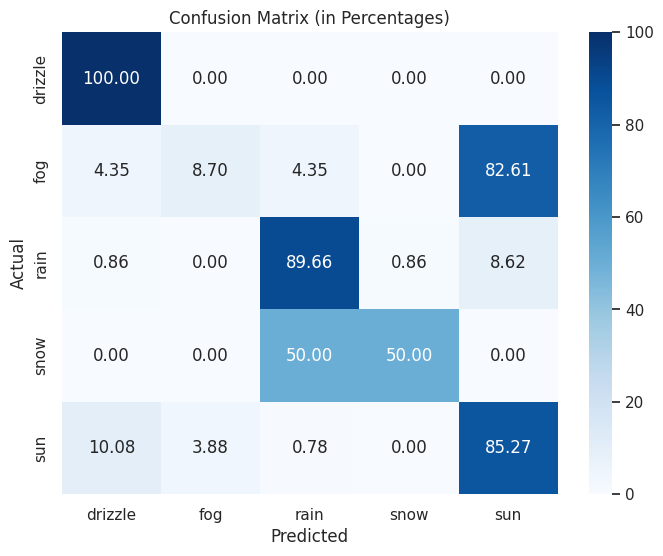

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (in Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
119 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 300}
Accuracy: 87.07%

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.90      1.00      0.95       138
         fog       0.33      0.09      0.14        23
        rain       0.98      0.90      0.94       116
        snow       0.67      0.50      0.57         4
         sun       0.79      0.86      0.82       129

    accuracy                           0.87       410
   macro avg       0.73      0.67      0.68       410
weighted avg       0.85      0.87      0.86       410



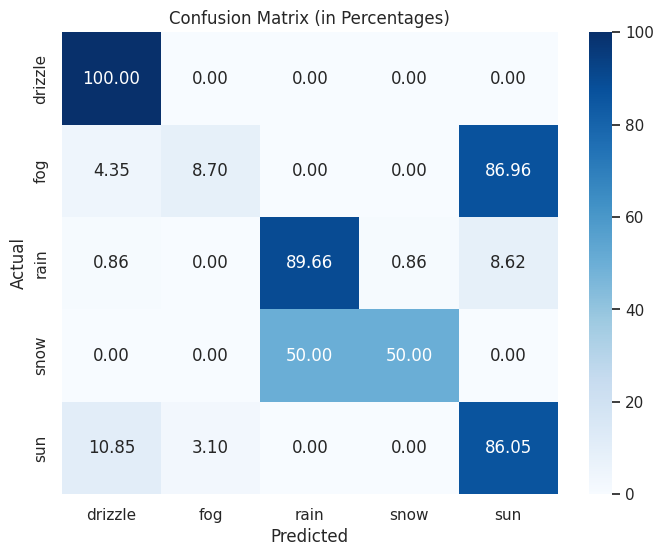

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the Random Forest model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rf_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (in Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ANN Model
ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)
ann_pred = np.argmax(ann.predict(X_test), axis=-1)
ann_accuracy = accuracy_score(y_test, ann_pred)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4568 - loss: 1.3283 - val_accuracy: 0.6159 - val_loss: 0.9600
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5878 - loss: 0.9857 - val_accuracy: 0.6098 - val_loss: 0.8812
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6103 - loss: 0.8888 - val_accuracy: 0.6311 - val_loss: 0.8362
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6505 - loss: 0.8209 - val_accuracy: 0.6768 - val_loss: 0.8062
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6637 - loss: 0.7795 - val_accuracy: 0.6585 - val_loss: 0.7846
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6723 - loss: 0.7680 - val_accuracy: 0.6951 - val_loss: 0.7648
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6803 - loss: 0.7469 - val_accuracy: 0.6890 - val_loss: 0.7528
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6881 - loss: 0.7300 - val_accuracy: 0.6951 - val_loss: 0.7

In [ ]:
# SVM Model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

In [ ]:
#Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

In [ ]:
# Sliding window function for time-series data
def create_sliding_windows(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])  # Include all features in each window
        y.append(target[i + window_size])    # Target corresponds to the end of the window
    return np.array(X), np.array(y)

# Define the window size for time-series
window_size = 5  # Number of timesteps per sequence

# Convert X to NumPy array (ensure it's numerical for sliding windows)
X_array = X.values  # Convert DataFrame to NumPy array if needed
y_array = y          # Target labels already encoded

# Create sliding windows for time-series
X_time_series, y_time_series = create_sliding_windows(X_array, y_array, window_size)

# Split data into training and testing sets
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(
    X_time_series, y_time_series, test_size=0.2, random_state=42
)

In [ ]:
# Reshape data for CNN
# Input format: (samples, timesteps, features)
X_train_cnn = X_train_ts.reshape((X_train_ts.shape[0], X_train_ts.shape[1], X_train_ts.shape[2]))
X_test_cnn = X_test_ts.reshape((X_test_ts.shape[0], X_test_ts.shape[1], X_test_ts.shape[2]))

# Define the CNN model
cnn = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=2, activation='relu', padding='same'),  # Add padding to preserve dimensions
    MaxPooling1D(pool_size=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_ts)), activation='softmax')  # Output layer with 'softmax' activation for multi-class classification
])

# Compile the CNN model
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train the CNN model
cnn.fit(X_train_cnn, y_train_ts, epochs=100, batch_size=16, validation_split=0.2)

# Make predictions with the CNN model
cnn_pred = np.argmax(cnn.predict(X_test_cnn), axis=-1)

# Evaluate the CNN model
cnn_accuracy = accuracy_score(y_test_ts, cnn_pred)

print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5692 - loss: 1.1788 - val_accuracy: 0.6422 - val_loss: 0.8692
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7163 - loss: 0.7259 - val_accuracy: 0.6697 - val_loss: 0.7947
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7662 - loss: 0.6196 - val_accuracy: 0.6728 - val_loss: 0.7734
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss: 0.6708 - val_accuracy: 0.6667 - val_loss: 0.7767
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497 - loss: 0.5994 - val_accuracy: 0.6789 - val_loss: 0.7426
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7554 - loss: 0.6011 - val_accuracy: 0.6881 - val_loss: 0.7418
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.5979 - val_accuracy: 0.6820 - val_loss: 0.7552
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7677 - loss: 0.5657 - val_accuracy: 0.7064 - val_loss: 0.7

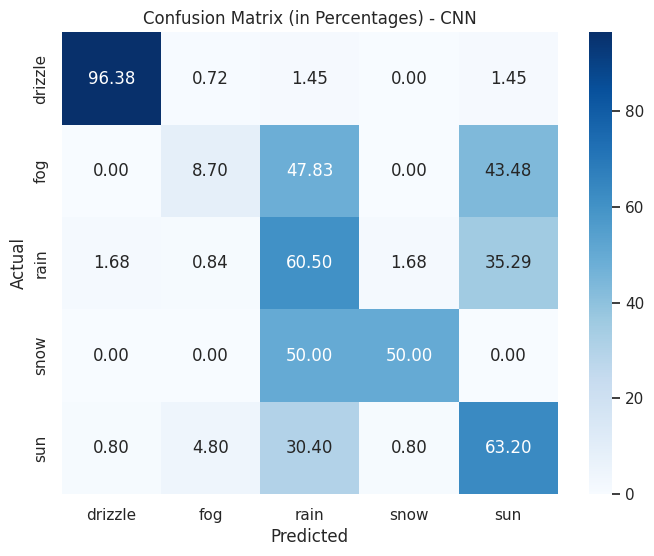

In [ ]:
conf_matrix = confusion_matrix(y_test_ts, cnn_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (in Percentages) - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
X_train_rnn = X_train_ts.reshape((X_train_ts.shape[0], X_train_ts.shape[1], X_train_ts.shape[2]))
X_test_rnn = X_test_ts.reshape((X_test_ts.shape[0], X_test_ts.shape[1], X_test_ts.shape[2]))

# Define the RNN model
rnn = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True),
    SimpleRNN(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_ts)), activation='softmax')  # Output layer with 'softmax' activation for multi-class classification
])

# Compile the RNN model
rnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train the RNN model
rnn.fit(X_train_rnn, y_train_ts, epochs=100, batch_size=16, validation_split=0.2)

# Make predictions with the RNN model
rnn_pred = np.argmax(rnn.predict(X_test_rnn), axis=-1)

# Evaluate the RNN model
rnn_accuracy = accuracy_score(y_test_ts, rnn_pred)

print(f"RNN Accuracy: {rnn_accuracy * 100:.2f}%")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5211 - loss: 1.2269 - val_accuracy: 0.6697 - val_loss: 0.8311
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7372 - loss: 0.6827 - val_accuracy: 0.6667 - val_loss: 0.7945
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7584 - loss: 0.6012 - val_accuracy: 0.6911 - val_loss: 0.7512
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7478 - loss: 0.6067 - val_accuracy: 0.7064 - val_loss: 0.7652
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7625 - loss: 0.5653 - val_accuracy: 0.7003 - val_loss: 0.7931
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7950 - loss: 0.5098 - val_accuracy: 0.7064 - val_loss: 0.7657
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8158 - loss: 0.5144 - val_accuracy: 0.7125 - val_loss: 0.7405
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7942 - loss: 0.4960 - val_accuracy: 0.6728 - val_loss: 0

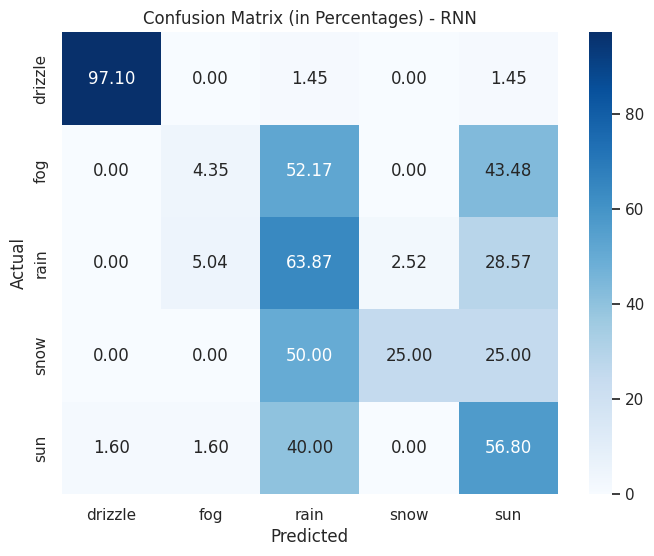

In [ ]:
conf_matrix = confusion_matrix(y_test_ts, rnn_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (in Percentages) - RNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

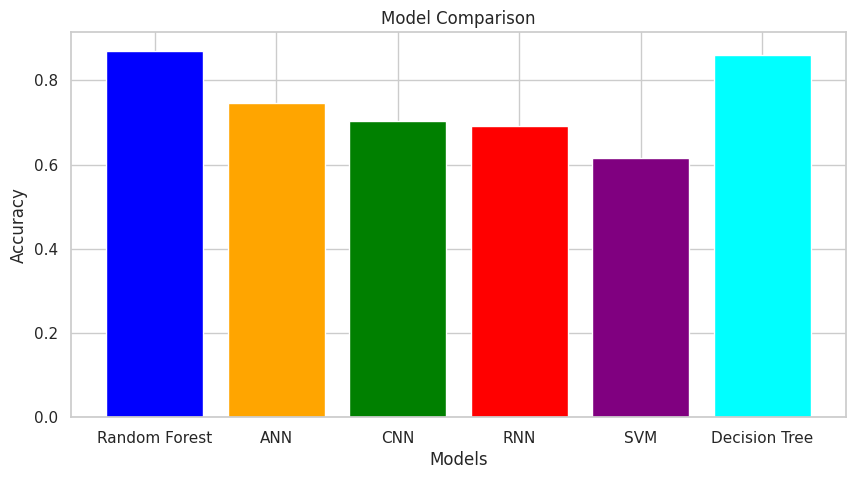

Random Forest Accuracy: 0.8707317073170732
ANN Accuracy: 0.7463414634146341
CNN Accuracy: 0.7041564792176039
RNN Accuracy: 0.6919315403422983
SVM Accuracy: 0.6146341463414634
Decision Tree Accuracy: 0.8609756097560975


In [ ]:
# Compare Models
models = ['Random Forest', 'ANN', 'CNN', 'RNN', 'SVM', 'Decision Tree']
accuracies = [rf_accuracy, ann_accuracy, cnn_accuracy, rnn_accuracy, svm_accuracy, dt_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"ANN Accuracy: {ann_accuracy}")
print(f"CNN Accuracy: {cnn_accuracy}")
print(f"RNN Accuracy: {rnn_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")

In [ ]:
# Train-test splits
splits = {'90-10': 0.1, '80-20': 0.20, '75-25': 0.25, '70-30': 0.3, '60-40': 0.4}
results = []

# Function to create and evaluate models
def evaluate_models(X_train, X_test, y_train, y_test):
    accuracies = {}

    # Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    accuracies['Random Forest'] = rf_accuracy

    # Decision Tree Model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_pred)
    accuracies['Decision Tree'] = dt_accuracy

    # ANN Model
    ann = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    ann_pred = np.argmax(ann.predict(X_test), axis=-1)
    ann_accuracy = accuracy_score(y_test, ann_pred)
    accuracies['ANN'] = ann_accuracy

    # CNN Model
    X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
    cnn = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    cnn_pred = np.argmax(cnn.predict(X_test_cnn), axis=-1)
    cnn_accuracy = accuracy_score(y_test, cnn_pred)
    accuracies['CNN'] = cnn_accuracy

    # RNN Model
    rnn = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    rnn_pred = np.argmax(rnn.predict(X_test_cnn), axis=-1)
    rnn_accuracy = accuracy_score(y_test, rnn_pred)
    accuracies['RNN'] = rnn_accuracy

    # SVM Model
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    accuracies['SVM'] = svm_accuracy

    return accuracies

In [ ]:
# Evaluate models for each split ratio
for split_name, split_ratio in splits.items():
    X_train, X_test, y_train, y_test = train_test_split(X[selected_features_final], y, test_size=split_ratio, random_state=42)
    accuracies = evaluate_models(X_train, X_test, y_train, y_test)
    accuracies['Split Ratio'] = split_name
    results.append(accuracies)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

   Random Forest  Decision Tree       ANN       CNN       RNN       SVM  \
0       0.902439       0.868293  0.678049  0.658537  0.707317  0.639024   
1       0.868293       0.860976  0.663415  0.641463  0.700000  0.614634   
2       0.876953       0.845703  0.710938  0.628906  0.687500  0.609375   
3       0.881301       0.850407  0.686179  0.652033  0.694309  0.613008   
4       0.864634       0.825610  0.687805  0.646341  0.678049  0.623171   

  Split Ratio  
0       90-10  
1       80-20  
2       75-25  
3       70-30  
4       60-40  


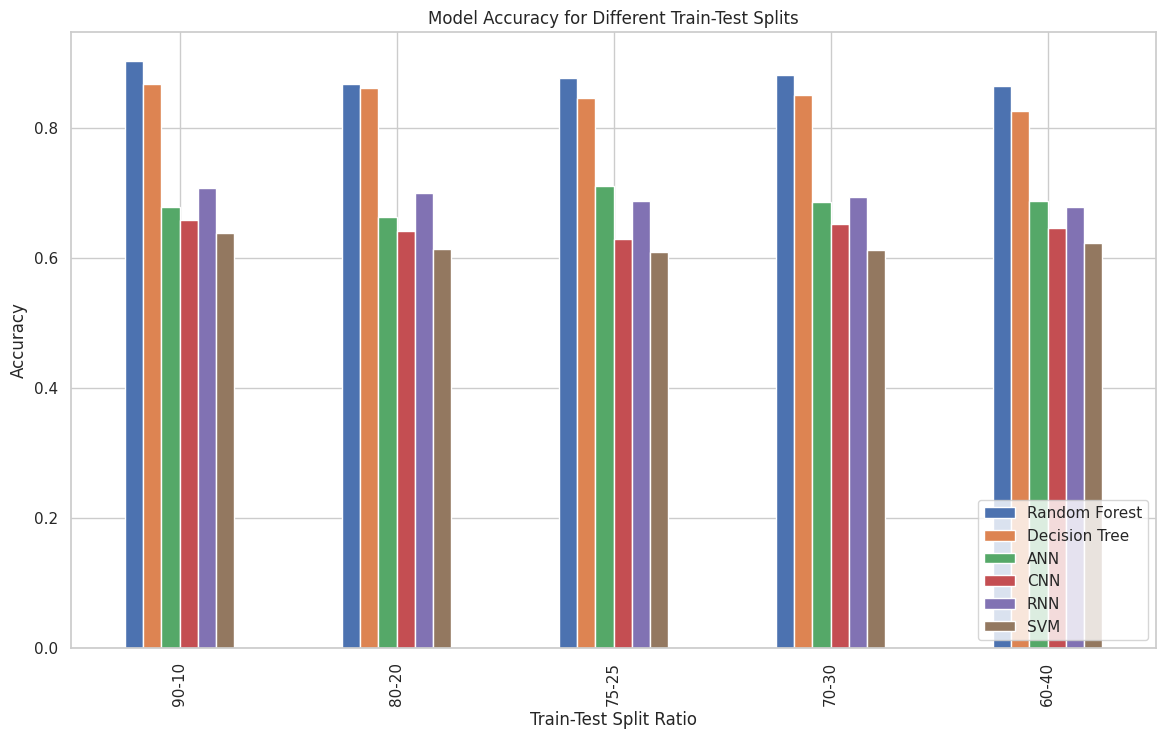

In [ ]:
# Visualize the results
results_df.set_index('Split Ratio', inplace=True)
results_df.plot(kind='bar', figsize=(14, 8))
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Train-Test Splits')
plt.legend(loc='lower right')
plt.show()